In [109]:
import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import sys, os

# Import my modules

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import timeseries

import warnings
warnings.filterwarnings('ignore')

In [110]:
area_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Ofx/areacello/gn/v20191108/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc'
area_cube = iris.load_cube(area_file, 'cell_area')
area_shape = list(area_cube.shape)
area_shape.insert(0, 840)
area_data = uconv.broadcast_array(area_cube.data, [1, 2], tuple(area_shape))

In [111]:
var_dict = {}
var_dict['hflux-coupler'] = 'surface heat flux coming through coupler'
var_dict['hflux-runoff'] = 'temperature_flux_due_to_runoff_expressed_as_heat_flux_into_sea_water'
var_dict['hflux-pme'] = 'heat flux (relative to 0C) from pme transfer of water across ocean surface'
var_dict['hfds'] = 'surface_downward_heat_flux_in_sea_water'

var_dict['pme-net'] = "precip-evap into ocean (total w/ restore + normalize)"
var_dict['runoff'] = 'water_flux_into_sea_water_from_rivers'
var_dict['wfo'] = 'water_flux_into_sea_water'

def get_files(experiment):
    """Get the files"""
    
    assert experiment in ['faf-heat', 'faf-water']

    file_dict = {}
    file_dict['hflux-coupler'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-coupler/gn/v20191210/sfc-hflux-coupler_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-runoff'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-from-runoff/gn/v20191210/sfc-hflux-from-runoff_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-pme'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-pme/gn/v20191210/sfc-hflux-pme_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hfds'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/hfds/gn/v20191210/hfds_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'

    file_dict['pme-net'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/pme-net/gn/v20191210/pme-net_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['runoff'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/runoff/gn/v20191210/runoff_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['wfo'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/wfo/gn/v20191210/wfo_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'

    return file_dict

In [112]:
def get_cubes(file_dict):
    """Get cubes"""

    cube_dict = {}
    for var in ['hflux-coupler', 'hflux-runoff', 'hflux-pme', 'hfds',
                'pme-net', 'runoff', 'wfo']:
        cube = iris.load_cube(file_dict[var], var_dict[var])
        assert cube.units in ['W m-2', 'kg m-2 s-1']
        out_units = 'W' if cube.units == 'W m-2' else 'kg s-1'
        cube = cube * area_data
        coord_names = [coord.name() for coord in cube.dim_coords]
        gs_cube = cube.collapsed(coord_names[1:], iris.analysis.SUM)
        gs_cube = timeseries.convert_to_annual(gs_cube)
        gs_cube.units = out_units
        cube_dict[var] = gs_cube
        
    return cube_dict

In [117]:
def plot_heat(experiment):

    file_dict = get_files(experiment)
    cube_dict = get_cubes(file_dict)

    plt.plot(cube_dict['hflux-coupler'].data, label='coupler', linestyle=':')
    plt.plot(cube_dict['hflux-runoff'].data, label='runoff', linestyle=':')
    plt.plot(cube_dict['hflux-pme'].data, label='pme', linestyle=':')
    plt.plot(cube_dict['hfds'].data, label='hfds')
    plt.ylabel(cube_dict['hfds'].units)
    plt.xlabel('year')
    plt.title(f'Total (global) annual heat flux, {experiment}')
    plt.legend()
    plt.show()

In [116]:
def plot_water(experiment):

    file_dict = get_files(experiment)
    cube_dict = get_cubes(file_dict)

    plt.plot(cube_dict['pme-net'].data, label='pme-net', linestyle=':')
    plt.plot(cube_dict['runoff'].data, label='runoff', linestyle=':')
    plt.plot(cube_dict['wfo'].data, label='wfo')
    plt.ylabel(cube_dict['wfo'].units)
    plt.xlabel('year')
    plt.title(f'Total (global) annual freshwater flux, {experiment}')
    plt.legend()
    plt.show()

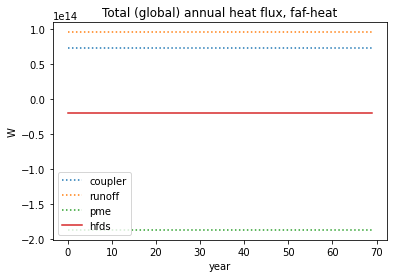

In [118]:
plot_heat('faf-heat')

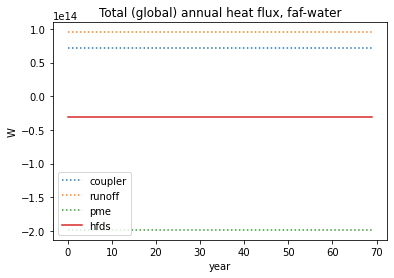

In [119]:
plot_heat('faf-water')

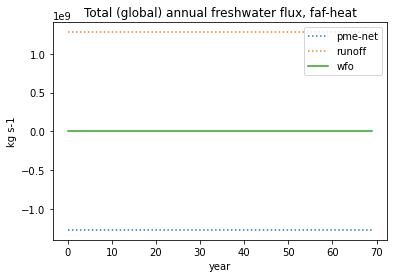

In [120]:
plot_water('faf-heat')

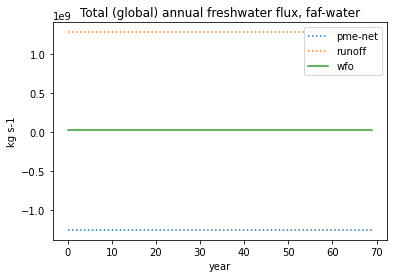

In [121]:
plot_water('faf-water')